# Numerical Simulation

### packages

In [ ]:
# Install packages if dont have already
# pip install numpy scipy cvxpy scs networkx matplotlib control

In [ ]:
# Import packages
import numpy as np
import scipy.linalg as la
import cvxpy as cp
import time
from typing import Dict, Any
import networkx as nx
import matplotlib.pyplot as plt
import control as ct
import time as systime

## A. Analysis

In [ ]:
# Graph types, line, star, ring, complete
def build_laplacian(N: int, gtype: int) -> np.ndarray:
    if gtype == 1:  # line
        A = np.zeros((N, N))
        for i in range(N-1):
            A[i, i+1] = 1
            A[i+1, i] = 1
    elif gtype == 2:  # star
        A = np.zeros((N, N))
        for j in range(1, N):
            A[0, j] = 1
            A[j, 0] = 1
    elif gtype == 3:  # ring
        A = np.zeros((N, N))
        for j in range(N):
            A[j, (j+1) % N] = 1
            A[(j+1) % N, j] = 1
    elif gtype == 4:  # complete
        A = np.ones((N, N)) - np.eye(N)
    else:
        raise ValueError("unknown gtype")
    deg = np.sum(A, axis=1)
    L = np.diag(deg) - A
    return L

# Brute-force Circle LMI (circle.m translated)
def solve_brute_force_circle(A, B, C, L, alpha, eps=1e-6, solver=cp.SCS, solver_opts=None) -> Dict[str, Any]:
    N = L.shape[0]
    n = A.shape[0]
    ny = C.shape[0]
    eigs = np.linalg.eigvals(L)
    lam_min = np.min(np.real(eigs))
    lam_max = np.max(np.real(eigs))

    Aagg = np.kron(np.eye(N), A)
    Bagg = np.kron(np.eye(N), B)
    Cagg = np.kron(L, C)

    P = cp.Variable((N*n, N*n), symmetric=True)
    W = cp.Variable((N*ny, N*ny), symmetric=True)

    top_left = Aagg.T @ P + P @ Aagg
    top_right = P @ Bagg + Cagg.T @ (alpha * W)
    bottom_right = -2.0 * W

    M = cp.bmat([[top_left, top_right],
                 [top_right.T, bottom_right]])

    solver_opts = solver_opts or {}
    constraints = [
        P >> eps * np.eye(N*n),
        W >> eps * np.eye(N*ny),
        -M >> eps * np.eye(N*n + N*ny)
    ]
    prob = cp.Problem(cp.Minimize(0), constraints)

    t0 = time.time()
    prob.solve(solver=solver, verbose=False, **solver_opts)
    t_elapsed = time.time() - t0

    feasible = prob.status in ('optimal', 'optimal_inaccurate')
    return {"feasible": feasible, 
            "status": prob.status, 
            "time": t_elapsed, 
            "P": P.value if feasible else None, 
            "W": W.value if feasible else None,
            "lambda_min": lam_min,
            "lambda_max": lam_max
    }

# Brute-force Popov LMI (popov.m translated)
def solve_brute_force_popov(A, B, C, L, alpha, eps=1e-6, solver=cp.SCS, solver_opts=None) -> Dict[str, Any]:
    N = L.shape[0]
    n = A.shape[0]
    ny = C.shape[0]

    eigs = np.linalg.eigvals(L)
    lam_min = np.min(np.real(eigs))
    lam_max = np.max(np.real(eigs))

    Aagg = np.kron(np.eye(N), A)
    Bagg = np.kron(np.eye(N), B)
    Cagg = np.kron(L, C)

    P = cp.Variable((N*n, N*n), symmetric=True)
    W = cp.Variable((N*ny, N*ny), symmetric=True)
    Npop = cp.Variable((N*ny, N*ny), symmetric=True)

    top_left = Aagg.T @ P + P @ Aagg
    AC_term = (Aagg.T @ Cagg.T) @ Npop  # corresponds to A' C' * Npop pattern from MATLAB code
    top_right = P @ Bagg + Cagg.T @ (alpha * W) + AC_term
    bottom_right = -2.0 * W + Npop @ (Cagg @ Bagg) + (Bagg.T @ Cagg.T) @ Npop

    M = cp.bmat([[top_left, top_right],
                 [top_right.T, bottom_right]])

    solver_opts = solver_opts or {}
    constraints = [
        P >> eps * np.eye(N*n),
        W >> eps * np.eye(N*ny),
        Npop >> eps * np.eye(N*ny),
        -M >> eps * np.eye(N*n + N*ny)
    ]
    prob = cp.Problem(cp.Minimize(0), constraints)

    t0 = time.time()
    prob.solve(solver=solver, verbose=False, **solver_opts)
    t_elapsed = time.time() - t0

    feasible = prob.status in ('optimal', 'optimal_inaccurate')
    return {"feasible": feasible, 
            "status": prob.status, 
            "time": t_elapsed, 
            "P": P.value if feasible else None, 
            "W": W.value if feasible else None, 
            "Npop": Npop.value if feasible else None,
            "lambda_min": lam_min,
            "lambda_max": lam_max
    }

# Scalable Circle LMI (circle_scale.m translated)
def solve_scalable_circle(A, B, C, L, alpha, eps=1e-6, solver=cp.SCS, solver_opts=None) -> Dict[str, Any]:
    eigs = np.linalg.eigvals(L)
    lam_min = np.min(np.real(eigs))
    lam_max = np.max(np.real(eigs))
    n = A.shape[0]
    ny = C.shape[0]

    P = cp.Variable((n, n), symmetric=True)
    W1 = cp.Variable((ny, ny), symmetric=True)
    W2 = cp.Variable((ny, ny), symmetric=True)

    TL1 = A.T @ P + P @ A
    TR1 = P @ B + lam_max * alpha * (C.T @ W1)
    BR1 = -2.0 * W1
    M1 = cp.bmat([[TL1, TR1], [TR1.T, BR1]])

    TL2 = A.T @ P + P @ A
    TR2 = P @ B + lam_min * alpha * (C.T @ W2)
    BR2 = -2.0 * W2
    M2 = cp.bmat([[TL2, TR2], [TR2.T, BR2]])

    solver_opts = solver_opts or {}
    constraints = [
        P >> eps * np.eye(n),
        W1 >> eps * np.eye(ny),
        W2 >> eps * np.eye(ny),
        -M1 >> eps * np.eye(n + ny),
        -M2 >> eps * np.eye(n + ny)
    ]
    prob = cp.Problem(cp.Minimize(0), constraints)
    t0 = time.time()
    prob.solve(solver=solver, verbose=False, **solver_opts)
    t_elapsed = time.time() - t0
    feasible = prob.status in ('optimal', 'optimal_inaccurate')
    return {"feasible": feasible, 
            "status": prob.status, 
            "time": t_elapsed, 
            "P": P.value if feasible else None, 
            "W1": W1.value if feasible else None, 
            "W2": W2.value if feasible else None,
            "lambda_min": lam_min,
            "lambda_max": lam_max
    }

# Scalable Popov LMI (popov_scale.m translated)
def solve_scalable_popov(A, B, C, L, alpha, eps=1e-6, solver=cp.SCS, solver_opts=None) -> Dict[str, Any]:
    eigs = np.linalg.eigvals(L)
    lam_min = np.min(np.real(eigs))
    lam_max = np.max(np.real(eigs))
    n = A.shape[0]
    ny = C.shape[0]

    P = cp.Variable((n, n), symmetric=True)
    W1 = cp.Variable((ny, ny), symmetric=True)
    W2 = cp.Variable((ny, ny), symmetric=True)
    eta = cp.Variable(nonneg=True)

    def build_M(lam, W):
        TL = A.T @ P + P @ A
        TR = P @ B + lam * (alpha * C.T @ W + eta * (A.T @ C.T))
        BR = -2.0 * W + 2.0 * eta * lam * (C @ B + (B.T @ C.T))
        return cp.bmat([[TL, TR], [TR.T, BR]])

    M1 = build_M(lam_min, W1)
    M2 = build_M(lam_max, W2)

    solver_opts = solver_opts or {}
    constraints = [
        P >> eps * np.eye(n),
        W1 >> eps * np.eye(ny),
        W2 >> eps * np.eye(ny),
        eta >= 0,
        -M1 >> eps * np.eye(n + ny),
        -M2 >> eps * np.eye(n + ny)
    ]
    prob = cp.Problem(cp.Minimize(0), constraints)
    t0 = time.time()
    prob.solve(solver=solver, verbose=False, **solver_opts)
    t_elapsed = time.time() - t0
    feasible = prob.status in ('optimal', 'optimal_inaccurate')
    return {"feasible": feasible, 
            "status": prob.status, 
            "time": t_elapsed, "P": P.value if feasible else None, 
            "W1": W1.value if feasible else None, 
            "W2": W2.value if feasible else None, 
            "eta": eta.value if feasible else None,
            "lambda_min": lam_min,
            "lambda_max": lam_max
    }

# Runner (example.m translated)
def runner_experiment(Nset, Gtype=1, alpha=0.09, solver=cp.SCS):
    results = []
    for N in Nset:
        L = build_laplacian(N, Gtype)
        A = np.array([[-2, 1, 0],
                      [1, -1, 1],
                      [0, -2, 0]], dtype=float)
        B = np.array([[0], [0], [3]], dtype=float)
        C = np.array([[1, 0, 0]], dtype=float)
        out_circ = solve_brute_force_circle(A, B, C, L, alpha, solver=solver)
        out_pop = solve_brute_force_popov(A, B, C, L, alpha, solver=solver)
        out_circ_scale = solve_scalable_circle(A, B, C, L, alpha, solver=solver)
        out_pop_scale = solve_scalable_popov(A, B, C, L, alpha, solver=solver)
        results.append({
            "N": N,
            "circ": out_circ,
            "pop": out_pop,
            "circ_scale": out_circ_scale,
            "pop_scale": out_pop_scale
        })
    return results

# MAIN
if __name__ == "__main__":
    Nset = [4, 8, 12, 32, 64, 100]
    print("Running experiment for N =", Nset)
    results = runner_experiment(Nset, Gtype=1, alpha=0.09, solver=cp.SCS)

    # Pretty summary with lambda_min and lambda_max added
    print("\nSummary:")
    header = (
        f"{'N':>3} | {'lambda_min':>10} {'lambda_max':>10} | "
        f"{'circ_time':>10} {'circ_feas':>10} | "
        f"{'pop_time':>10} {'pop_feas':>10} | "
        f"{'circScale_time':>14} {'circScale_feas':>14} | "
        f"{'popScale_time':>13} {'popScale_feas':>13}"
    )
    print(header)
    print("-" * len(header))

    for r in results:
        lam_min = r['circ_scale']['lambda_min']
        lam_max = r['circ_scale']['lambda_max']
        print(
            f"{r['N']:>3} | {lam_min:>10.3f} {lam_max:>10.3f} | "
            f"{r['circ']['time']:>10.3f} {str(r['circ']['feasible']):>10} | "
            f"{r['pop']['time']:>10.3f} {str(r['pop']['feasible']):>10} | "
            f"{r['circ_scale']['time']:>14.3f} {str(r['circ_scale']['feasible']):>14} | "
            f"{r['pop_scale']['time']:>13.3f} {str(r['pop_scale']['feasible']):>13}"
        )



Running experiment for N = [4, 8, 12, 32, 64, 100]

Summary:
  N | lambda_min lambda_max |  circ_time  circ_feas |   pop_time   pop_feas | circScale_time circScale_feas | popScale_time popScale_feas
-----------------------------------------------------------------------------------------------------------------------------------------
  4 |     -0.000      3.414 |      0.012       True |      0.006       True |          0.005           True |         0.007          True
  8 |      0.000      3.848 |      0.007       True |      0.006       True |          0.005           True |         0.007          True
 12 |      0.000      3.932 |      0.007       True |      0.008       True |          0.005           True |         0.007          True
 32 |     -0.000      3.990 |      0.033       True |      0.039       True |          0.005           True |         0.007          True
 64 |      0.000      3.998 |      0.135       True |      0.184       True |          0.005           True |  

## B. Synthesis

In [4]:
def lqr_lure_scale(syst, L_laplacian, alpha, Q, R):
    """
    Python implementation of the LMI-based feasibility test

    Function uses the Circle criterion to test the stability of a
    multi-agent system for a given sector bound alpha

    Parameters:
    syst (dict): A dictionary containing the system matrices 'a', 'b1', 'b2', 'c'.
    L_laplacian (np.ndarray): The Laplacian matrix of the network's graph.
    alpha (float): The upper bound of the sector nonlinearity.
    Q (np.ndarray): State weighting matrix for LQR.
    R (np.ndarray): Input weighting matrix for LQR.

    Returns:
    dict: A dictionary containing the LMI solutions or an error message.
    """
    # Parameters
    A = syst['a']
    B1 = syst['b1']
    B2 = syst['b2']
    C = syst['c']

    # n = state dimension, m = input dimension
    n, m = B2.shape  
    
    # Ensure R is a matrix for inversion
    if isinstance(R, (int, float)):
        R = np.array([[R]])

    # Eigenvalues of the Laplacian
    Lambda = np.linalg.eigvals(L_laplacian)
    lam_min = np.min(Lambda)
    lam_max = np.max(Lambda)

    tstart = systime.time()
    
    # LMI variable definitions using CVXPY
    Y = cp.Variable((n, n), symmetric=True)
    U1 = cp.Variable()
    U2 = cp.Variable()
    L = cp.Variable((m, n))
    eta = cp.Variable()  # Scalar to be minimized

    # Prepare constant matrices
    R_inv = np.linalg.inv(R)
    Q_inv = np.linalg.inv(Q)

    # LMI Constraints
    constraints = []

    # First LMI (with lam_min)
    M1 = cp.bmat([
        [A @ Y + Y @ A.T + B2 @ L + L.T @ B2.T, B1 * U1 + alpha * lam_min * Y @ C.T, L.T, Y],
        [(B1 * U1 + alpha * lam_min * Y @ C.T).T, -2 * U1 * np.eye(m), np.zeros((m, m)), np.zeros((m, n))],
        [L, np.zeros((m, m)), -R_inv, np.zeros((m, n))],
        [Y, np.zeros((n, m)), np.zeros((n, m)), -Q_inv]
    ])
    constraints.append(M1 << 0)

    # Second LMI (with lam_max)
    M2 = cp.bmat([
        [A @ Y + Y @ A.T + B2 @ L + L.T @ B2.T, B1 * U2 + alpha * lam_max * Y @ C.T, L.T, Y],
        [(B1 * U2 + alpha * lam_max * Y @ C.T).T, -2 * U2 * np.eye(m), np.zeros((m, m)), np.zeros((m, n))],
        [L, np.zeros((m, m)), -R_inv, np.zeros((m, n))],
        [Y, np.zeros((n, m)), np.zeros((n, m)), -Q_inv]
    ])
    constraints.append(M2 << 0)
    
    # Third LMI: Y > 0
    constraints.append(Y >> 1e-9 * np.eye(n)) # Add small epsilon for numerical stability

    # Fourth LMI: Minimize eta s.t. [ -eta*I, I; I, -Y ] <= 0
    M4 = cp.bmat([
        [-eta * np.eye(n), np.eye(n)],
        [np.eye(n), -Y]
    ])
    constraints.append(M4 << 0)

    # Solve the problem
    objective = cp.Minimize(eta)
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=False) 
    
    telapsed = systime.time() - tstart
    print(f"LMI solved in {telapsed:.4f} seconds. Status: {problem.status}")

    # Return solution
    if problem.status in ["optimal", "optimal_inaccurate"]:
        Y_val = Y.value
        L_val = L.value
        
        K_val = L_val @ np.linalg.inv(Y_val)

        data = {
            'Y': Y_val,
            'U1': U1.value,
            'U2': U2.value,
            'L': L_val,
            'K': K_val,
            'eta': eta.value,
            'status': problem.status
        }
        return data
    else:
        return {'status': problem.status, 'error': 'Solver failed or the problem is infeasible.'}

Running synthesis for a 3-graph with 32 agents...
LMI solved in 1.1554 seconds. Status: optimal_inaccurate

--- Synthesis Results ---
Solver status: optimal_inaccurate
Minimized eta: 171.7584
Optimal Controller Gain (K):
[[-55.82997047 -15.00823258  -5.17859235]]
-------------------------

Simulating system response...


/Users/sharmin/Desktop/SP/.venv/lib/python3.13/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


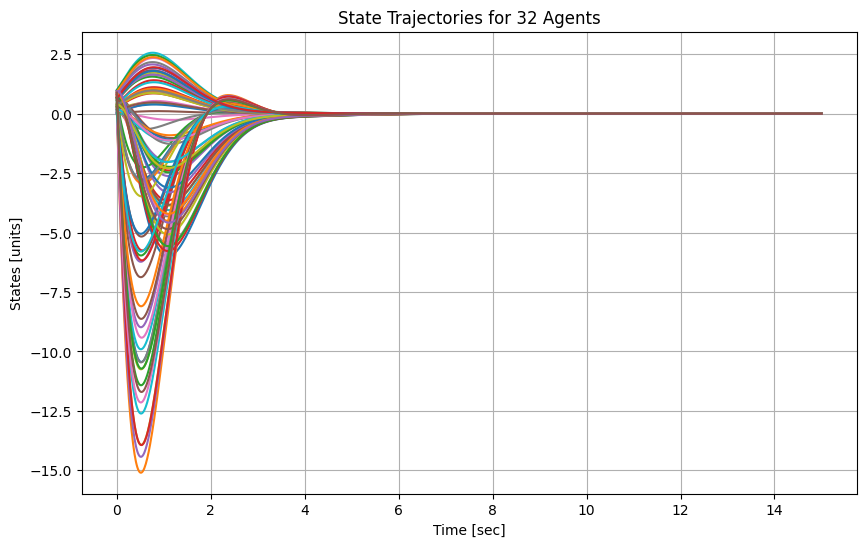

In [5]:
# Setup for synthesis

# 1 = line; 2 = star; 3 = ring; 4 = complete
Gtype = 3
N = 32 # Number of agents

# Graphs and Laplacians
if Gtype == 1:
    # Undirected line graph
    G = nx.path_graph(N)
elif Gtype == 2:
    # Undirected star graph
    G = nx.star_graph(N - 1)
elif Gtype == 3:
    # Undirected ring graph
    G = nx.cycle_graph(N)
elif Gtype == 4:
    # Complete (all-to-all) graph
    G = nx.complete_graph(N)
else:
    raise ValueError("Invalid Gtype specified.")

# Convert from sparse to full matrix
L = nx.laplacian_matrix(G).toarray()

# System definition for a single agent
P1 = {
    'a': np.array([[2, 1, 0], [1, -1, 1], [0, -2, 0]]),
    'b1': np.array([[0], [0], [3]]),
    'b2': np.array([[0], [0], [1]]),
    'c': np.array([[1, 0, 0]])
}
n, m = P1['b2'].shape

# Synthesis algorithm
alpha = 1.0
Q = 1 * np.eye(n)
R = 1

print(f"Running synthesis for a {Gtype}-graph with {N} agents...")
data = lqr_lure_scale(P1, L, alpha, Q, R)

if 'error' in data:
    print(f"Synthesis failed: {data['error']}")
else:
    # Print results from solver
    print("\n--- Synthesis Results ---")
    print(f"Solver status: {data['status']}")
    print(f"Minimized eta: {data['eta']:.4f}")
    
    K = data['K']
    print(f"Optimal Controller Gain (K):\n{K}")
    print("-------------------------\n")
    
    # Construct aggregate closed-loop system
    A_cl = np.kron(np.eye(N), P1['a'] + P1['b2'] @ K)
    
    # Create state-space model representing closed-loop system
    sys_closed_loop = ct.ss(A_cl, np.zeros((n * N, 1)), np.eye(n * N), 0)

    # Plot sample results
    
    x0 = np.random.rand(n * N)
    T = np.linspace(0, 15, 1000) # Simulate for 15 seconds

    print("Simulating system response...")
    # Simulate the response of the system to the initial condition x0
    time, yout = ct.initial_response(sys_closed_loop, T=T, X0=x0)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(time, yout.T)
    plt.xlabel('Time [sec]')
    plt.ylabel('States [units]')
    plt.title(f'State Trajectories for {N} Agents')
    plt.grid(True)
    plt.show()